In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from audiffuse import Audiffuse
from es_dataset import EpidemicSoundDataset
from lightning.pytorch.utilities.deepspeed import convert_zero_checkpoint_to_fp32_state_dict

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

[2023-09-08 20:43:38,586] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [37]:
try:
    os.remove('/scratch/korte/audiffuse/full_model.ckpt')
except:
    print('No file to remove')
ckpt_path = '/scratch/korte/audiffuse/lightning_logs/version_3/checkpoints/last.ckpt/'
# ckpt_path = '/scratch/korte/audiffuse/lightning_logs/version_5/checkpoints/diffuser-epoch=039-val/loss=0.13.ckpt/'
convert_zero_checkpoint_to_fp32_state_dict(ckpt_path, '/scratch/korte/audiffuse/full_model.ckpt')

No file to remove
Processing zero checkpoint '/scratch/korte/audiffuse/lightning_logs/version_3/checkpoints/last.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 8
Parsing checkpoint created by deepspeed==0.10.2
Reconstructed Frozen fp32 state dict with 446 params 114993646 elements
Reconstructed fp32 state dict with 686 params 859520964 elements
Saving fp32 state dict to /scratch/korte/audiffuse/full_model.ckpt


In [41]:
ckpt = torch.load('/scratch/korte/audiffuse/full_model.ckpt')

In [44]:
ckpt.keys()
# ckpt['frozen_param_fragments'].keys()

dict_keys(['buffer_names', 'param_shapes', 'frozen_param_shapes', 'shared_params', 'frozen_param_fragments', 'data_sampler', 'random_ltd', 'sparse_tensor_module_names', 'global_samples', 'ds_config', 'ds_version', 'epoch', 'global_step', 'pytorch-lightning_version', 'loops', 'callbacks', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'state_dict'])

In [45]:
for key in ckpt['state_dict'].keys():
    if 'cond_stage_model' in key:
        print(key)

_forward_module.cond_stage_model.spectrogram_extractor.stft.conv_real.weight
_forward_module.cond_stage_model.spectrogram_extractor.stft.conv_imag.weight
_forward_module.cond_stage_model.logmel_extractor.melW
_forward_module.cond_stage_model.bn0.weight
_forward_module.cond_stage_model.bn0.bias
_forward_module.cond_stage_model.patch_embed.proj.weight
_forward_module.cond_stage_model.patch_embed.proj.bias
_forward_module.cond_stage_model.patch_embed.norm.weight
_forward_module.cond_stage_model.patch_embed.norm.bias
_forward_module.cond_stage_model.patch_embed.mel_conv2d.weight
_forward_module.cond_stage_model.patch_embed.mel_conv2d.bias
_forward_module.cond_stage_model.patch_embed.fusion_model.local_att.0.weight
_forward_module.cond_stage_model.patch_embed.fusion_model.local_att.0.bias
_forward_module.cond_stage_model.patch_embed.fusion_model.local_att.1.weight
_forward_module.cond_stage_model.patch_embed.fusion_model.local_att.1.bias
_forward_module.cond_stage_model.patch_embed.fusion_m

In [42]:
ckpt['hyper_parameters']

{'first_stage_ckpt': '/scratch/korte/audiffuse/autoencoder_ckpt',
 'cond_stage_ckpt': '/scratch/korte/audiffuse/clap.ckpt',
 'diffuser_config': DiffuserConfig(),
 'lr': 0.0001,
 'use_lr_scheduler': False,
 'loss_func': 'mse',
 'noise_scheduler_timesteps': 1000,
 'scale_by_std': False,
 'scale_factor': 0.1857,
 'val_gen_freq': 5,
 'freeze_cond_stage': True}

In [38]:
model = Audiffuse.load_from_checkpoint('/scratch/korte/audiffuse/full_model.ckpt')
# model = Audiffuse(**ckpt['hyper_parameters'])
# model.load_state_dict(ckpt['state_dict'], strict=False)
model = model.to('cuda')

In [6]:
dataset = EpidemicSoundDataset('/fastscratch/korte/es-dataset/')

In [17]:
img = dataset[120]['album_art']
song = dataset[120]['audio']

for key in song:
    if isinstance(song[key], torch.Tensor):
        song[key] = song[key].unsqueeze(0).to(model.device)

In [18]:
print(song['waveform'].shape)

torch.Size([1, 480000])


In [20]:
t = 200

with torch.no_grad():
    model.diffuser_model.train()
    model.noise_scheduler.set_timesteps(1000)

    encoded_audio = model.encode_audio(song)

    latents = model.encode_images(img.unsqueeze(0).to(model.device))
    noise = torch.randn((1, 4, 64, 64)).to(model.device)
    noisy_latents = model.noise_scheduler.add_noise(latents, noise, torch.tensor(t))

    latents = noisy_latents.clone()
    
    # latents = torch.randn((1, 4, 64, 64)).to(model.device)

    for t in tqdm(model.noise_scheduler.timesteps[-t:]):
        input_latents = latents
        input_latents = model.noise_scheduler.scale_model_input(latents, t)
        pred_noise = model(input_latents, t, encoded_audio).sample
        latents = model.noise_scheduler.step(pred_noise, t, latents, return_dict=False)[0]

    images = model.decode_latents(latents)

  0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
latents.max(), latents.min(), latents.mean(), latents.std()

(tensor(1., device='cuda:0'),
 tensor(-1., device='cuda:0'),
 tensor(-0.0874, device='cuda:0'),
 tensor(0.6434, device='cuda:0'))

In [22]:
images.min(), images.max(), images.mean(), images.std()

(tensor(-0.5191, device='cuda:0'),
 tensor(0.8374, device='cuda:0'),
 tensor(0.1835, device='cuda:0'),
 tensor(0.3316, device='cuda:0'))

In [ ]:
with torch.no_grad():
    t = 10
    latents = model.encode_images(img.unsqueeze(0).to(model.device)).sample()
    noise = torch.randn((1, 4, 64, 64)).to(model.device)
    latents = model.noise_scheduler.add_noise(latents, noise, torch.tensor(t))
    latents = model.noise_scheduler.scale_model_input(latents, t)
    pred_noise = model(latents, t, encoded_audio).sample
    print(F.mse_loss(pred_noise, noise))

In [8]:
test_timesteps = torch.randint(0, model.noise_scheduler.config.num_train_timesteps, (16,), device=latents.device, dtype=torch.half).long()
print(test_timesteps)

tensor([506,  23, 980, 220, 117, 904,  96,   7,  21, 595, 317,   0, 486, 372,
        218, 851], device='cuda:0')


In [23]:
img = img.cpu().numpy() * 0.5 + 0.5
images = images[0].cpu().numpy() + 0.5

In [24]:
images.min(), images.max()

(-0.019123554, 1.337379)

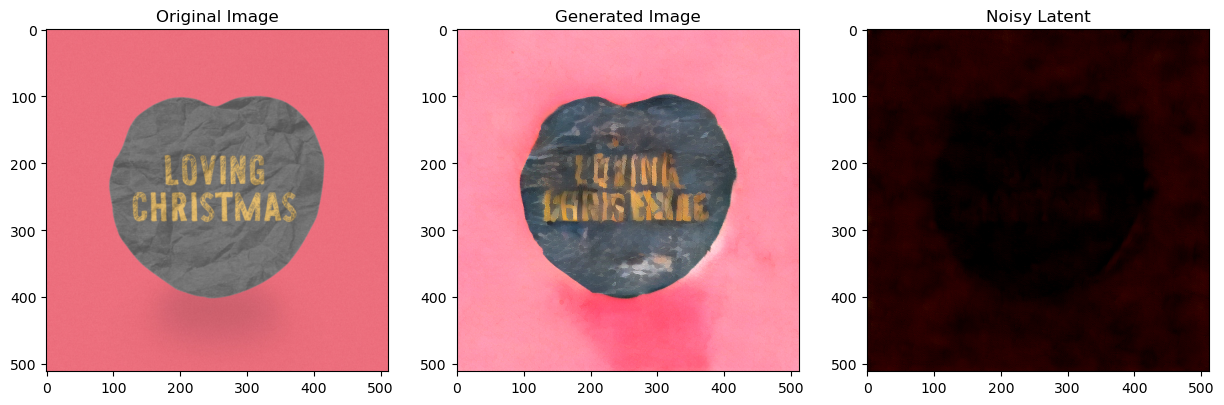

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img.transpose(1, 2, 0).clip(0, 1))
axs[0].set_title('Original Image')
axs[1].imshow(images.transpose(1, 2, 0).clip(0, 1))
axs[1].set_title('Generated Image')
axs[2].imshow(model.first_stage_model.decode(noisy_latents).sample[0].cpu().numpy().transpose(1, 2, 0).clip(0, 1))
axs[2].set_title('Noisy Latent')
plt.show()